# HighD Trajectory Data Analysis

## Brief Introduction to HighD

HighD is a dataset collected by Aachen University, German. This dataset "includes post-processed trajectories of 110 000 vehicles including cars and trucks extracted from drone video recordings at German highways around Cologne during 2017 and 2018. At six different locations, 60 recordings were made with an average length of 17 minutes (16.5 h in total) covering a road segment of about 420 m length. Each vehicle is visible for a median duration of 13.6 s."

This repository provides a data sample including less than 5% of the original dataset. It also provides a visualized insight into the complete dataset. For those interested in accessing the complete dataset, please follow this [link](https://www.highd-dataset.com/).

### Specialties about HighD dataset

HighD is the first trajectory dataset published by LevelX. Its annotations are slightly different from its siblings InD, RounD.

- **coordinate system**: The coordinate system of the HighD dataset is unique. As is shown in the following figure. It starts from the left-upper position of the road. If you want to restore the trajectories, it will be better reverse the y-axis (use $(x,-y)$ instead of $(x,y)$).

- **location of vehicles**: The HighD dataset take left-upper corner of the bounding box to represent the location of every vehicle.

- **disaligned original points**: The original points of coordinate system are different from file to file, even for the same map.

*FYI. There is no speed limit to highway in Germany.*

### Trajectory Types in HighD

In highD, all trajectory are from vehicles. All vehicles fall into two categories:

- `Car`
- `Truck`

### Match Trajectory Data with Maps

According to meta records:

- Trajectory data files 01-03 are recorded in location 2 (denoted as highD_2)
- Trajectory data files 04-06 are recorded in location 3 (denoted as highD_3)
- Trajectory data files 07-10 are recorded in location 4 (denoted as highD_4)
- Trajectory data files 11-14, 25-57 are recorded in location 1 (denoted as highD_1)
- Trajectory data files 15-24 are recorded in location 5 (denoted as highD_5)
- Trajectory data files 58-60 are recorded in location 6 (denoted as highD_6)

In [1]:
import sys

sys.path.append(".")

import warnings

warnings.filterwarnings("ignore")

import json

import matplotlib.transforms as mtransforms

from utils import levelx

with open("../map/map.config", "r") as f:
    configs = json.load(f)

data_path = "../trajectory/highD/data"
img_path = "../img/highD"
trajectory_types = ["Car", "Truck"]

## Data Analysis

The data analysis will first present visualizations of both the map and trajectory data and then analysis the speed distribution and lane changing frequency of vehicles, categorized by their types.

### Map and Trajectory Visualization

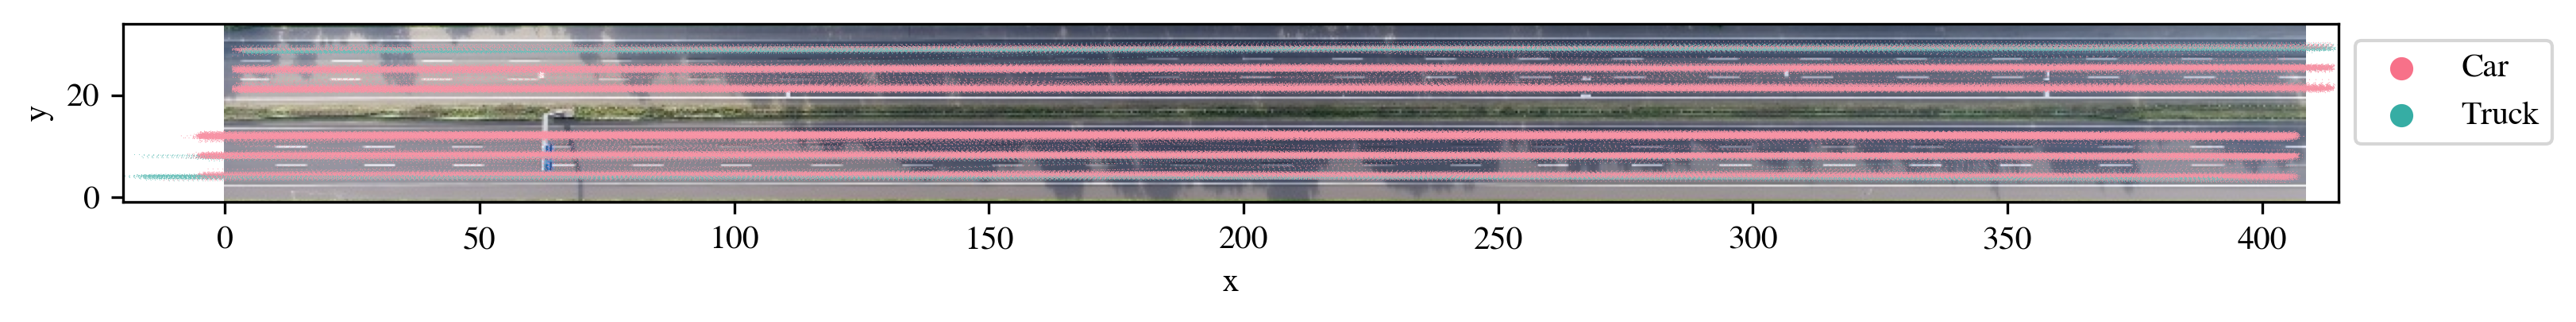

In [2]:
transform1 = mtransforms.Affine2D().scale(0.4, 0.4).translate(0, -1)
levelx.plot_map_and_trajectories(
    "highD_1", data_path, img_path, transform1, trajectory_types, configs
)

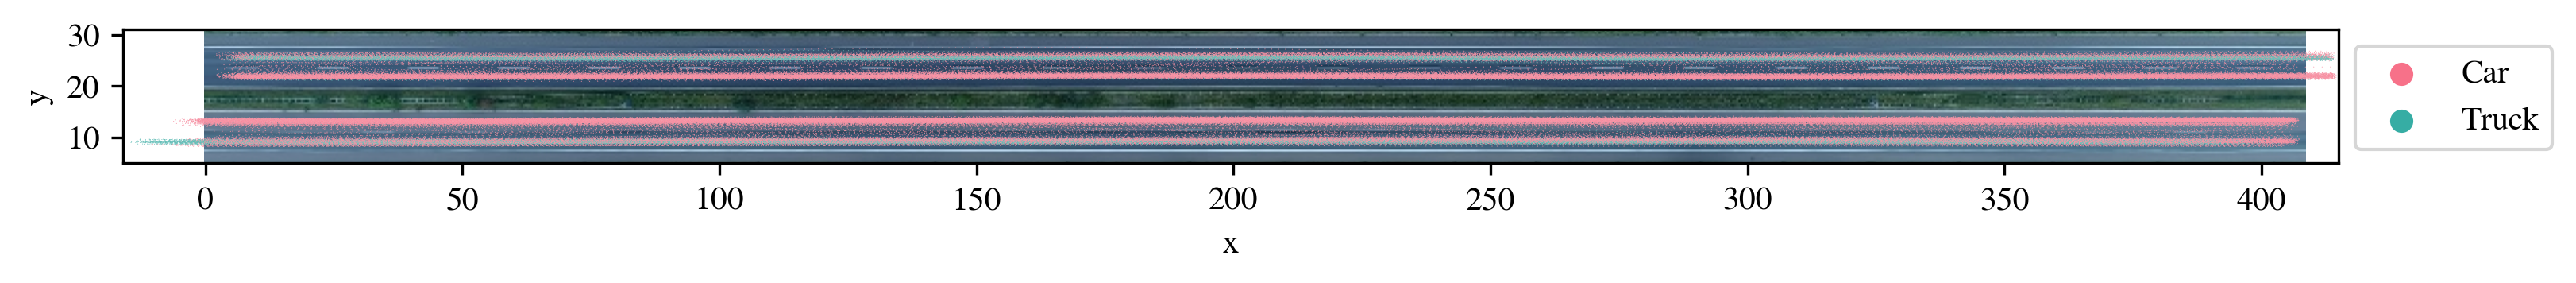

In [3]:
transform2 = mtransforms.Affine2D().scale(0.4, 0.4).translate(0, -1)
levelx.plot_map_and_trajectories(
    "highD_2", data_path, img_path, transform2, trajectory_types, configs
)

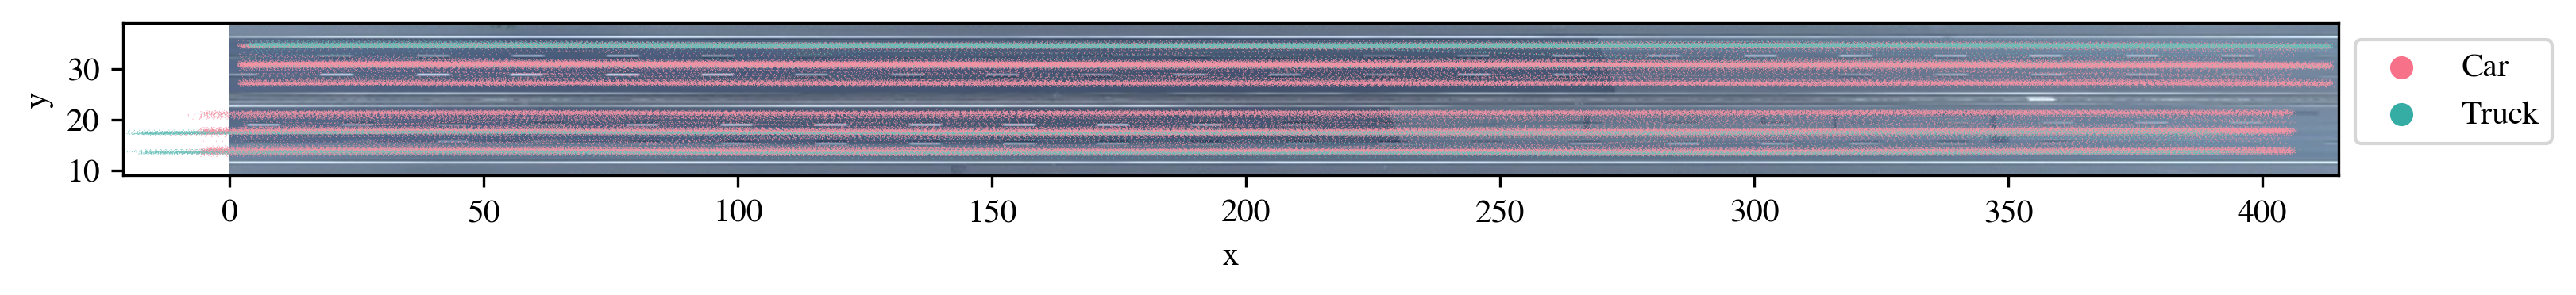

In [4]:
transform3 = mtransforms.Affine2D().scale(0.412, 0.412).translate(0, -1.65)
levelx.plot_map_and_trajectories(
    "highD_3", data_path, img_path, transform3, trajectory_types, configs
)

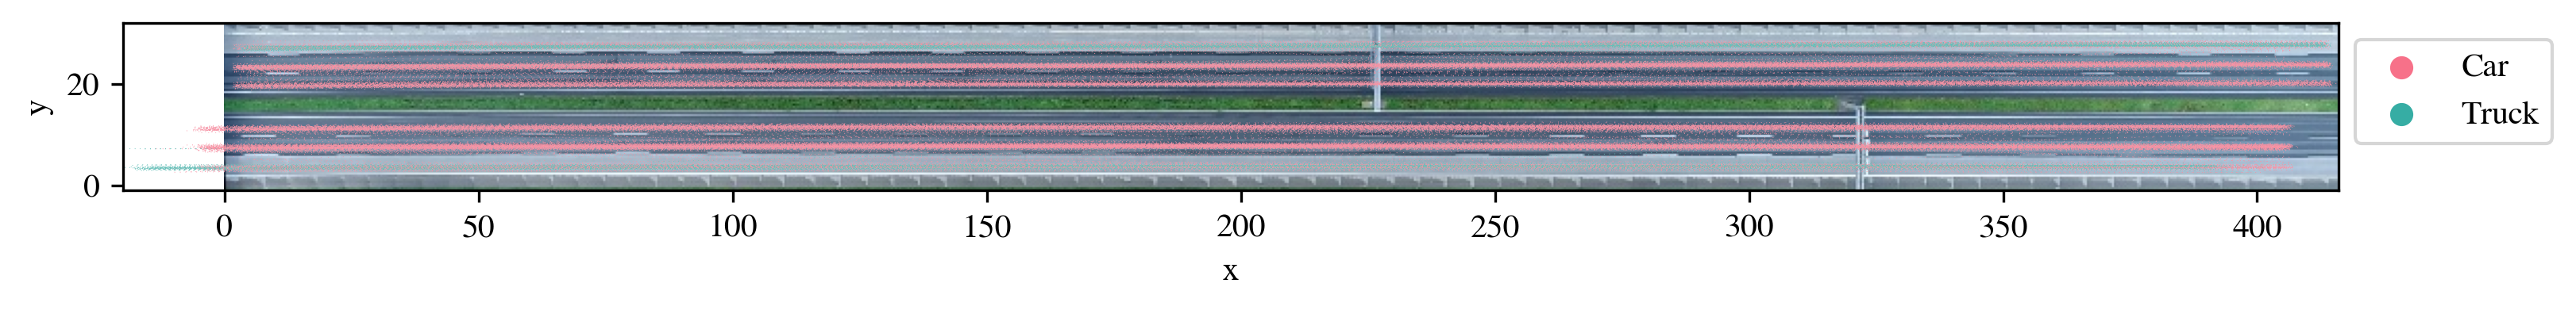

In [5]:
transform4 = mtransforms.Affine2D().scale(0.41, 0.41).translate(0, -1)
levelx.plot_map_and_trajectories(
    "highD_4", data_path, img_path, transform4, trajectory_types, configs
)

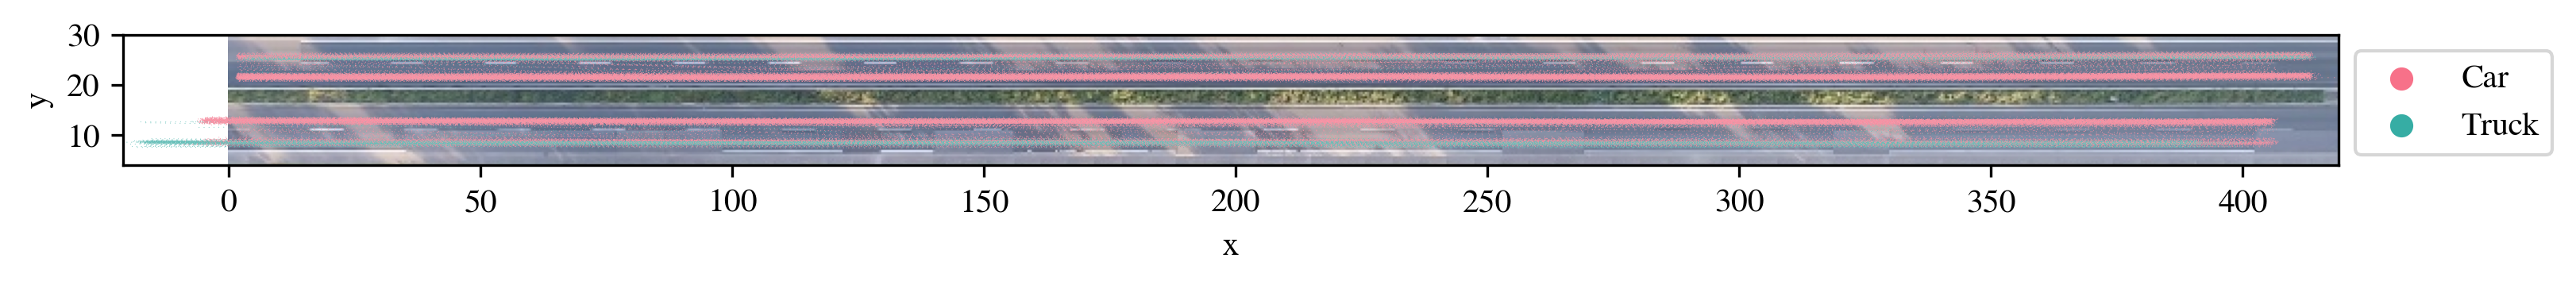

In [6]:
transform5 = mtransforms.Affine2D().scale(0.4267, 0.4267).translate(0, -1.3)
levelx.plot_map_and_trajectories(
    "highD_5", data_path, img_path, transform5, trajectory_types, configs
)

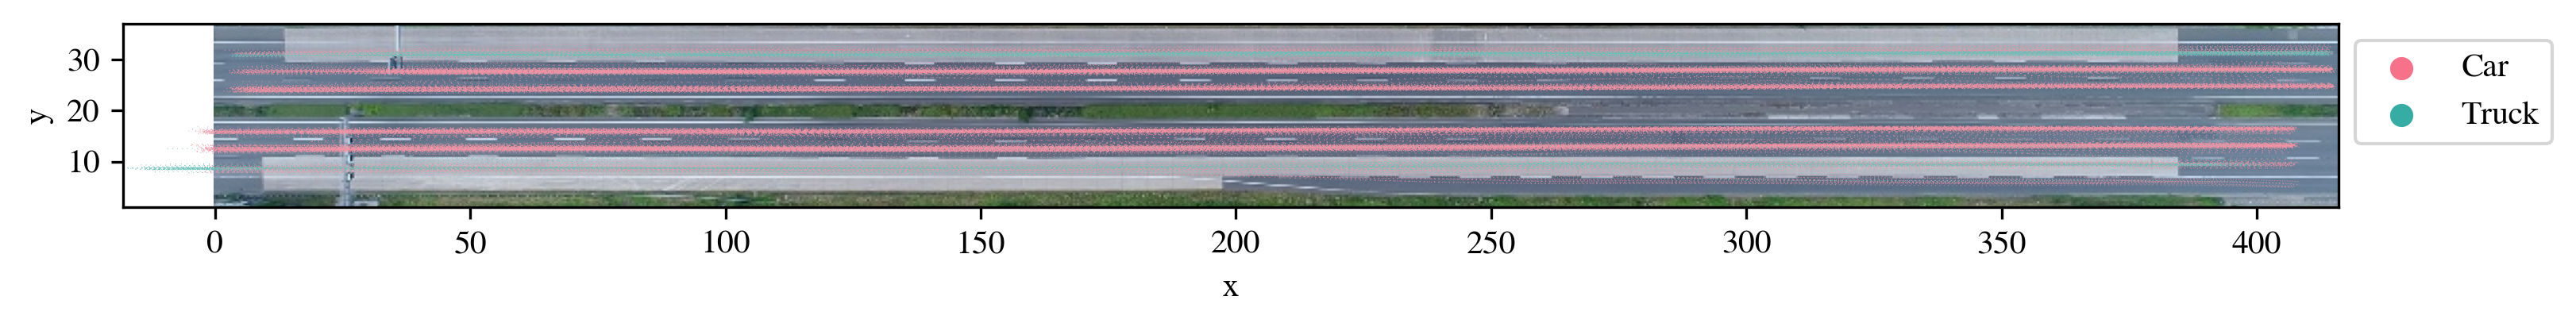

In [7]:
transform6 = mtransforms.Affine2D().scale(0.4115, 0.4115).translate(0, -1.74)
levelx.plot_map_and_trajectories(
    "highD_6", data_path, img_path, transform6, trajectory_types, configs
)

### Proportion of Vehicle Types

### Lane Changing Frequency

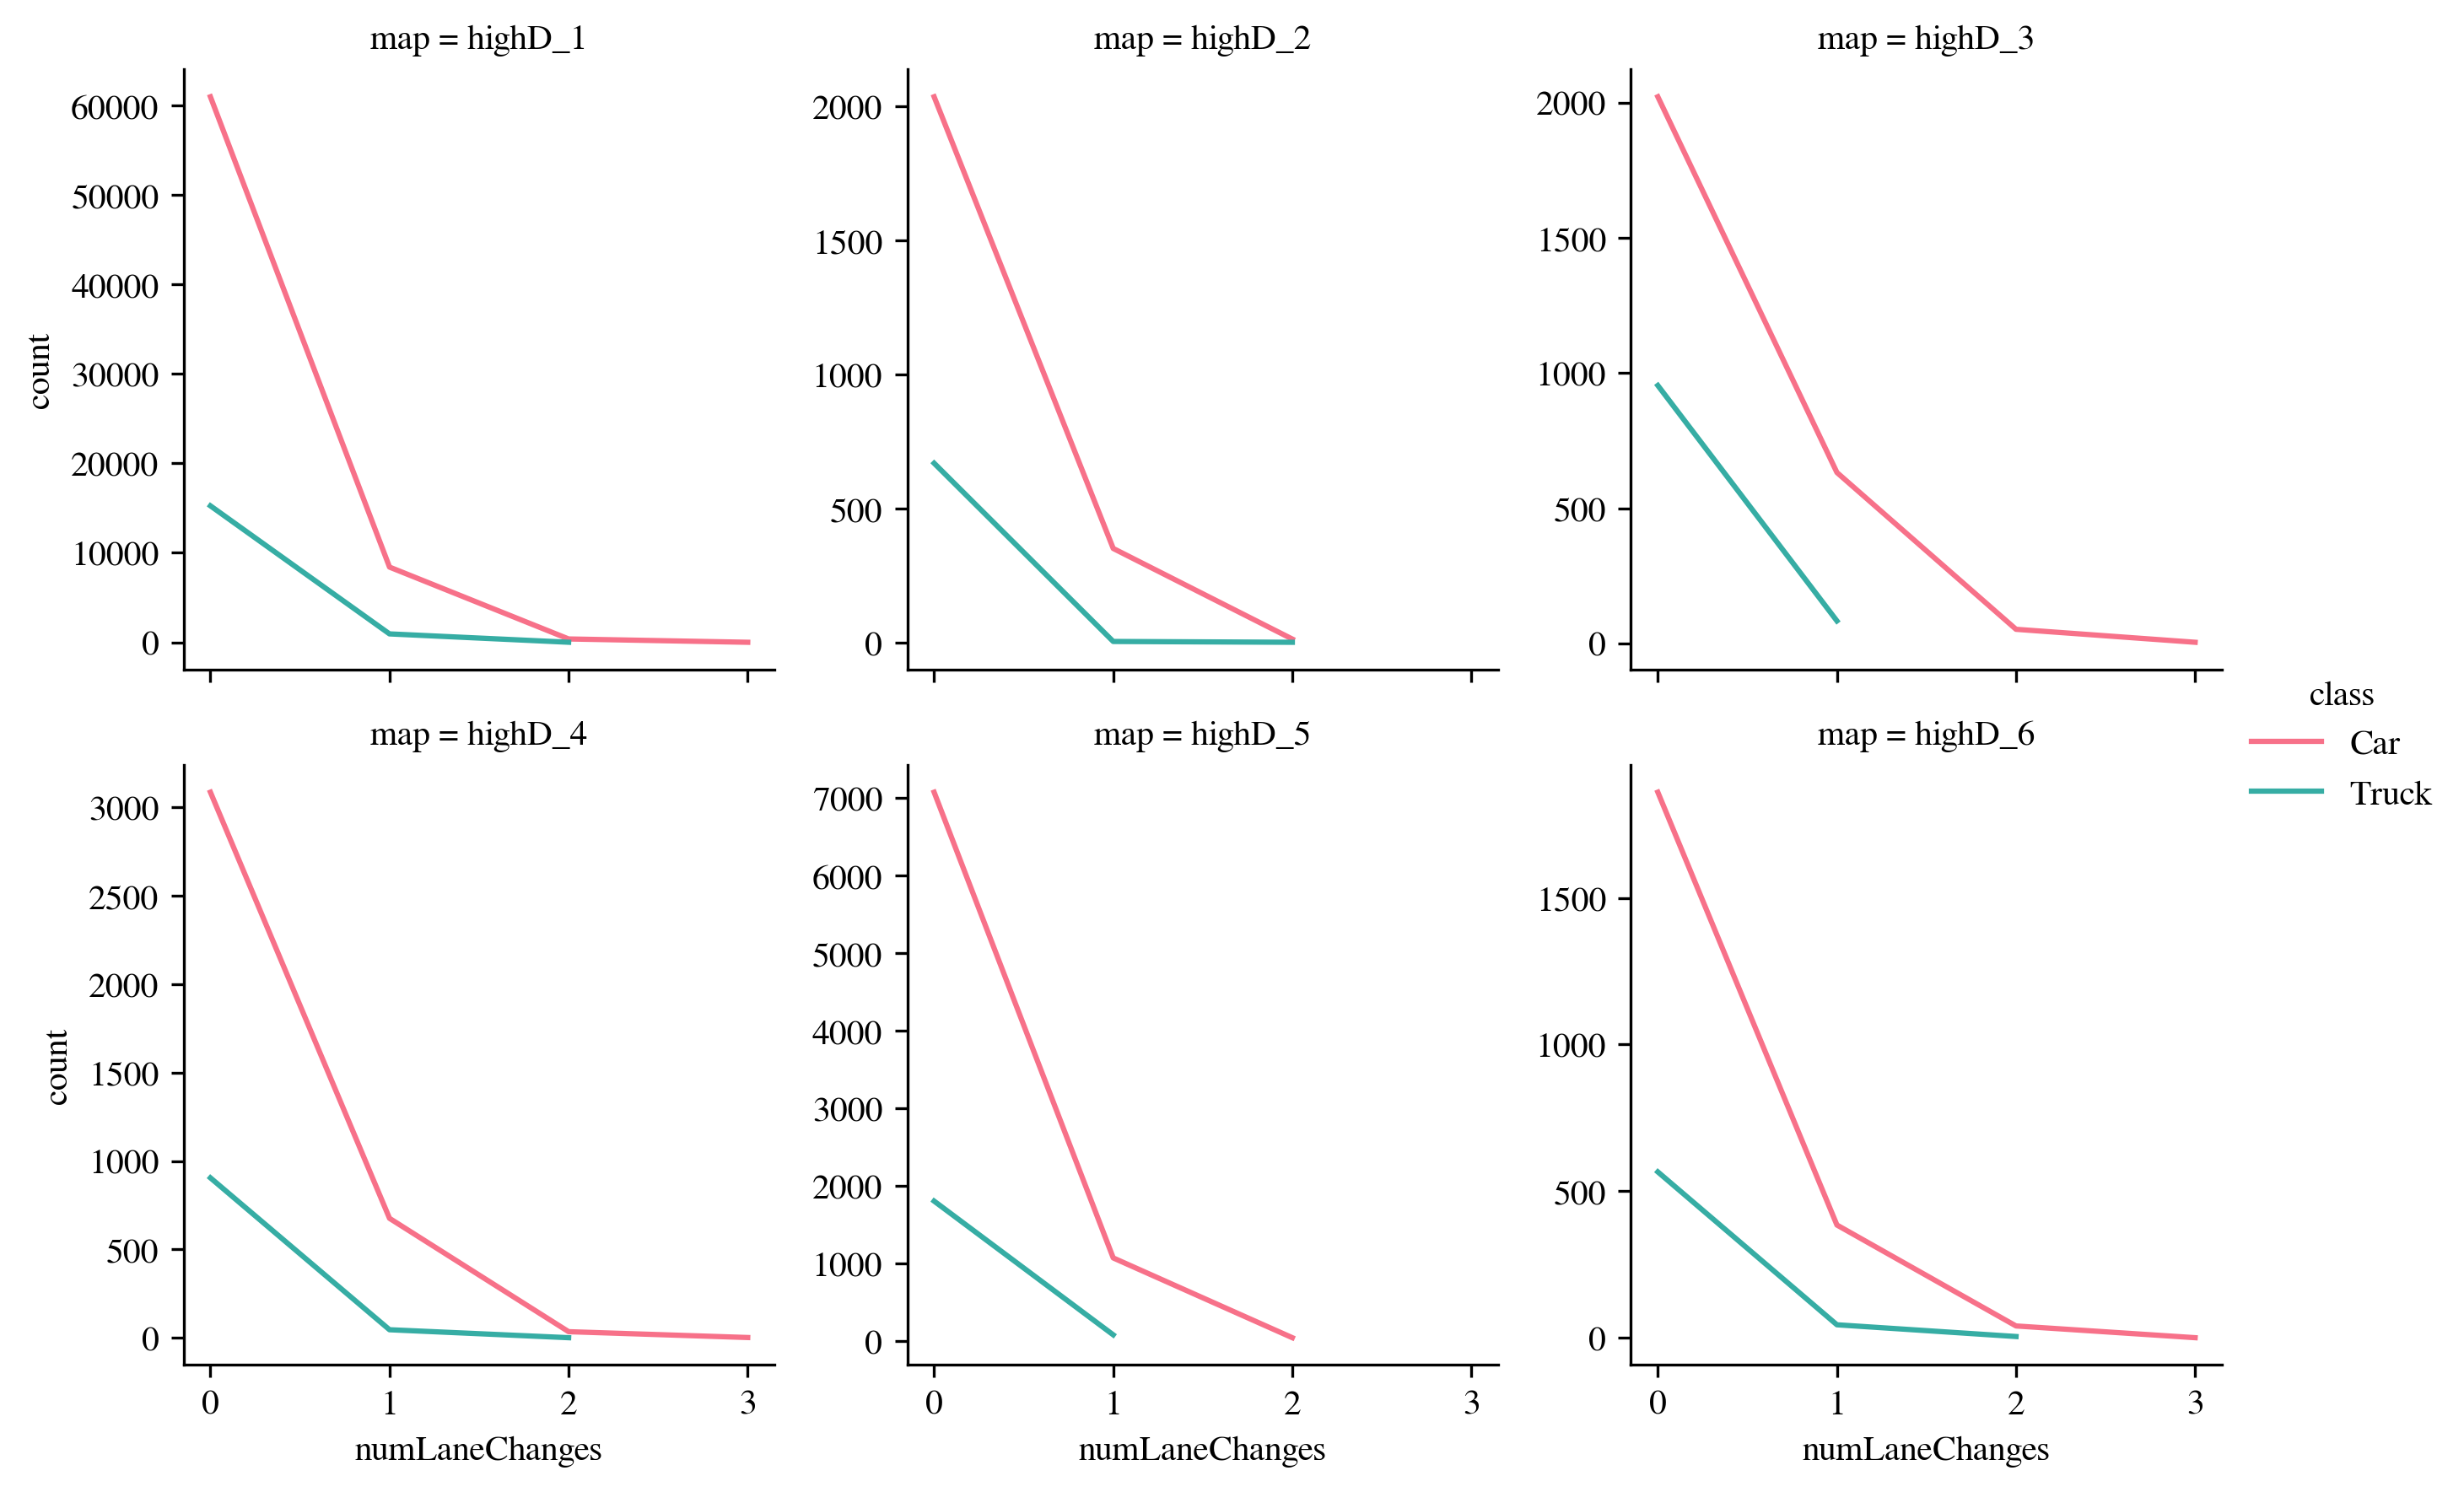

In [8]:
levelx.plot_lane_change_distribution("highD", data_path, trajectory_types, configs)

### Speed Distribution



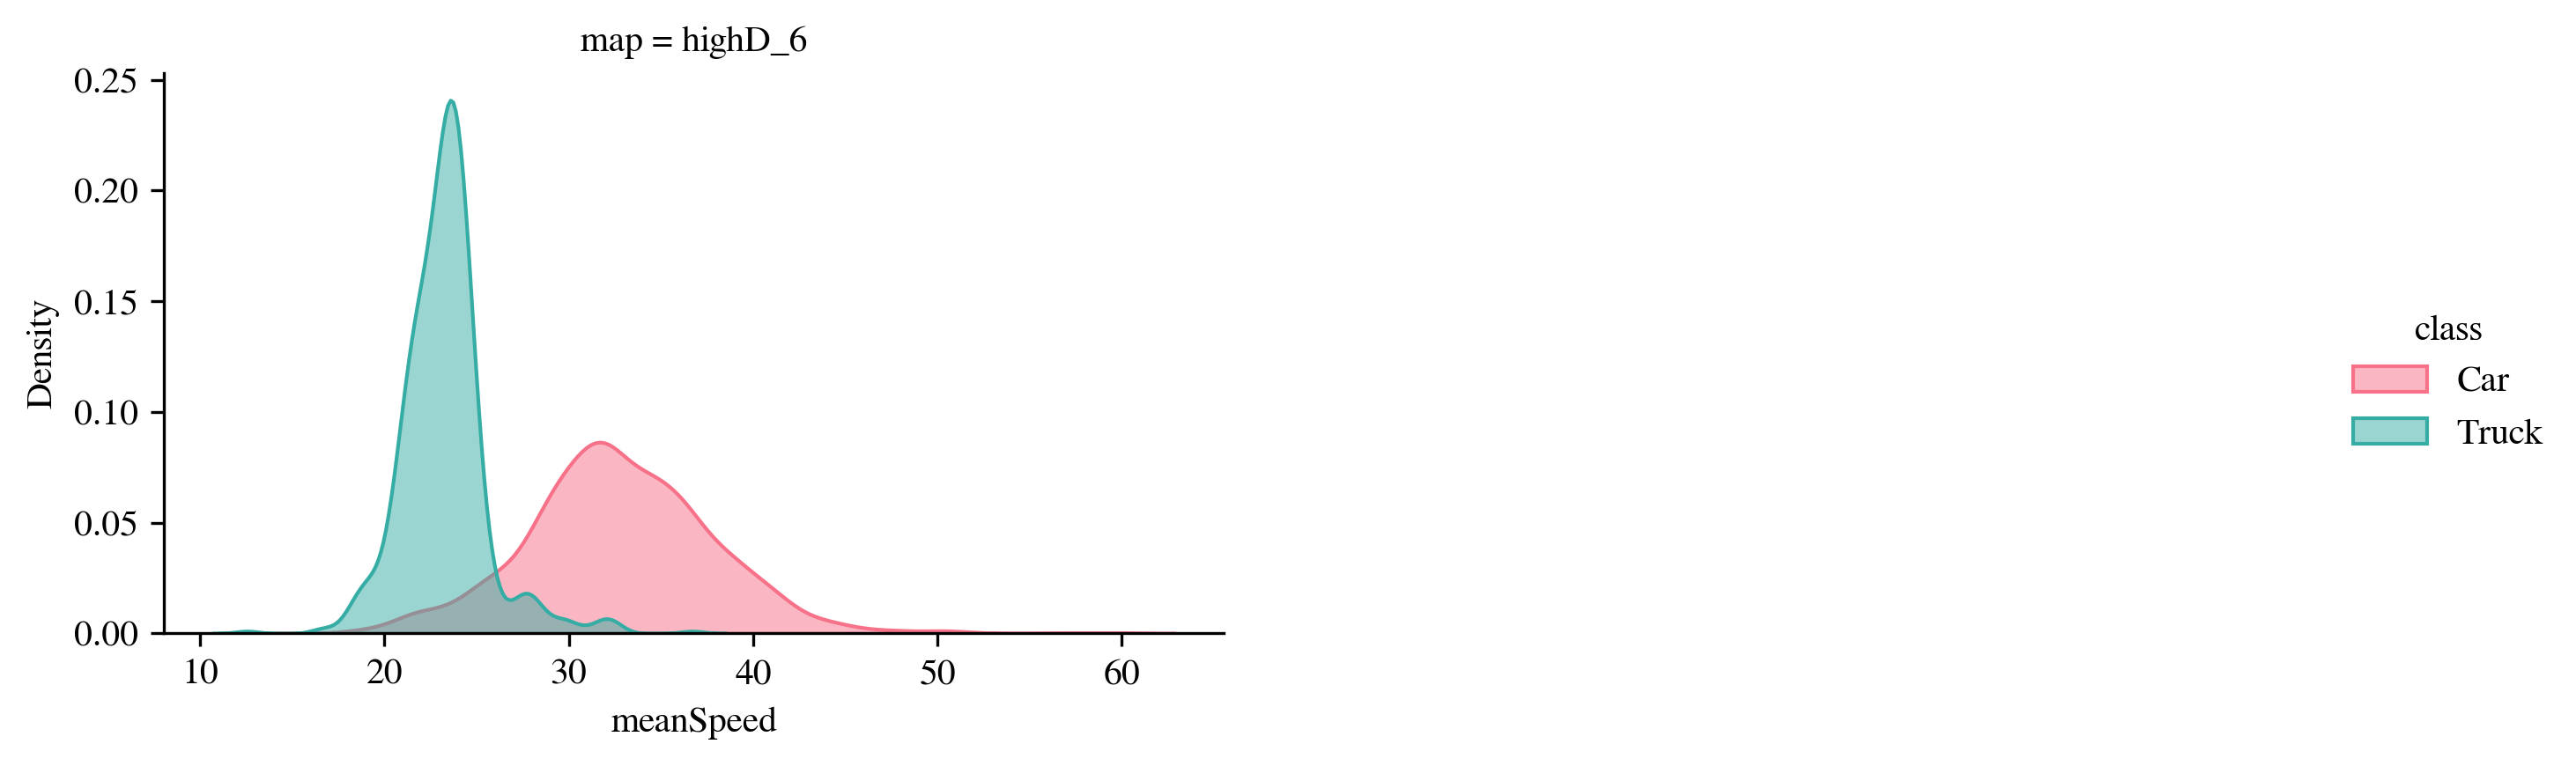

In [9]:
levelx.plot_speed_distribution("highD", data_path, trajectory_types, configs)

In [10]:
def plot_passing_time(file_ids):
    car_passing_time = []
    truck_passing_time = []
    for id in file_ids:
        df = pd.read_csv("%s/%02d_tracks.csv" % (data_path, id))
        df_meta = pd.read_csv(
            "%s/%02d_tracksMeta.csv" % (data_path, id), index_col="id"
        )
        vehicle_ids = df["id"].unique()
        for v_id in vehicle_ids:
            df_sub = df[df["id"] == v_id].reset_index()
            if abs(df_sub.iloc[-1]["x"] - df_sub.iloc[0]["x"]) < 300:
                pass
            else:
                if df_meta.loc[v_id, "class"] == "Car":
                    car_passing_time.append(
                        (df_sub.iloc[-1]["frame"] - df_sub.iloc[0]["frame"]) / 25
                    )
                else:
                    truck_passing_time.append(
                        (df_sub.iloc[-1]["frame"] - df_sub.iloc[0]["frame"]) / 25
                    )
    print("Average passing time of the cars is %.03f s." % np.mean(car_passing_time))
    print("Maximum passing time of the cars is %.03f s." % np.max(car_passing_time))
    print("STD of the cars' passing time is %.03f s." % np.std(car_passing_time))
    print(
        "Average passing time of the trucks is %.03f s." % np.mean(truck_passing_time)
    )
    print("Max passing time of the trucks is %.03f s." % np.max(truck_passing_time))
    print("STD of the trucks' passing time is %.03f s." % np.std(truck_passing_time))
    sns.distplot(car_passing_time, label="car", color="cornflowerblue")
    sns.distplot(truck_passing_time, label="truck", color="salmon")
    plt.xlabel("Passing time")
    plt.legend()
    plt.show()

In [11]:
def plot_speed_distribution(file_ids):
    car_velocity = []
    truck_velocity = []
    for id in file_ids:
        df = pd.read_csv("%s/%02d_tracks.csv" % (data_path, id))
        df_meta = pd.read_csv("%s/%02d_tracksMeta.csv" % (data_path, id))
        car_id = list(df_meta[df_meta["class"] == "Car"]["id"])
        df_car = df[df["id"].isin(car_id)]
        car_velocity += list(
            np.sqrt(np.square(df_car["xVelocity"]) + np.square(df_car["yVelocity"]))
        )
        truck_id = list(df_meta[df_meta["class"] == "Truck"]["id"])
        df_truck = df[df["id"].isin(truck_id)]
        truck_velocity += list(
            np.sqrt(np.square(df_truck["xVelocity"]) + np.square(df_truck["yVelocity"]))
        )

    print("Average speed of the cars is %.03f s." % np.mean(car_velocity))
    print("Maximum speed of the cars is %.03f s." % np.max(car_velocity))
    print("Minimum speed of the cars is %.03f s." % np.max(car_velocity))
    print("STD of the cars' speed is %.03f s." % np.std(car_velocity))
    print("Average speed of the trucks is %.03f s." % np.mean(truck_velocity))
    print("Maximum speed of the trucks is %.03f s." % np.max(truck_velocity))
    print("Minimum speed of the trucks is %.03f s." % np.max(truck_velocity))
    print("STD of the trucks speed is %.03f s." % np.std(truck_velocity))
    sns.distplot(car_velocity, label="car", color="cornflowerblue")
    sns.distplot(truck_velocity, label="truck", color="salmon")
    plt.xlabel("Speed distribution of every file")
    plt.legend()
    plt.show()

In [12]:
def count_lane_changing(file_ids):
    for id in file_ids:
        df_meta = pd.read_csv(
            "%s/%02d_tracksMeta.csv" % (data_path, id), index_col="id"
        )
        change_times = [0, 0, 0]
        for i in range(3):
            change_times[i] = np.sum(df_meta["numLaneChanges"] == i)
        print("File id: %d has %d tracks in total." % (id, len(df_meta)))
        print("\t%d vehicles never changes lane." % change_times[0])
        print("\t%d vehicles change lane for once." % change_times[1])
        print("\t%d vehicles change lane for twice." % change_times[2])

In [13]:
def plot_traffic_density(file_ids):
    for id in file_ids:
        df = pd.read_csv("%s/%02d_tracks.csv" % (data_path, id))
        df_meta = pd.read_csv("%s/%02d_tracksMeta.csv" % (data_path, id))
        car_id = list(df_meta[df_meta["class"] == "Car"]["id"])
        df_car = df[df["id"].isin(car_id)]
        truck_id = list(df_meta[df_meta["class"] == "Truck"]["id"])
        df_truck = df[df["id"].isin(truck_id)]
        last_frame = np.max(df["frame"])
        count_car = []
        count_truck = []
        for f in range(last_frame):
            count_car.append(len(df_car[df_car["frame"] == f + 1]))
            count_truck.append(len(df_truck[df_truck["frame"] == f + 1]))
        print("File id: %d" % id)
        sns.lineplot(list(range(1, last_frame + 1)), count_car, label="car")
        sns.lineplot(list(range(1, last_frame + 1)), count_truck, label="truck")
        plt.xlabel("Frame")
        plt.legend()
        plt.show()

### highD_0 (location 2)

#### Trajectories

In [14]:
plot_trajectories(config["H_highD_0_DEU"]["track_files"])

NameError: name 'plot_trajectories' is not defined

#### Average Passing Time

In [ ]:
plot_passing_time(config["H_highD_0_DEU"]["track_files"])

#### Speed Distribution

In [ ]:
plot_speed_distribution(config["H_highD_0_DEU"]["track_files"])

#### Count Number of Lane Changing

In [ ]:
count_lane_changing(config["H_highD_0_DEU"]["track_files"])

#### Traffic Density

In [ ]:
plot_traffic_density(config["H_highD_0_DEU"]["track_files"])

### highD_1 (location 3)

#### Trajectories

In [ ]:
plot_trajectories(config["H_highD_1_DEU"]["track_files"])

#### Average Passing Time

In [ ]:
plot_passing_time(config["H_highD_1_DEU"]["track_files"])

#### Speed Distribution

In [ ]:
plot_speed_distribution(config["H_highD_1_DEU"]["track_files"])

#### Count Number of Lane Changing

In [ ]:
count_lane_changing(config["H_highD_1_DEU"]["track_files"])

#### Traffic Density

In [ ]:
plot_traffic_density(config["H_highD_1_DEU"]["track_files"])

### highD_2 (location 4)

#### Trajectories

In [ ]:
plot_trajectories(config["H_highD_2_DEU"]["track_files"])

In [ ]:
plot_passing_time(config["H_highD_2_DEU"]["track_files"])

#### Speed Distribution

In [ ]:
plot_speed_distribution(config["H_highD_2_DEU"]["track_files"])

#### Count Number of Lane Changing

In [ ]:
count_lane_changing(config["H_highD_2_DEU"]["track_files"])

In [ ]:
plot_traffic_density(config["H_highD_2_DEU"]["track_files"])

### highD_3 (location 1)

#### Trajectories

The trajectory visualization of location 1 proofs that the origin points of the coordinate system are different from file to file.

In [ ]:
plot_trajectories(config["H_highD_3_DEU"]["track_files"])

In [ ]:
plot_passing_time(config["H_highD_3_DEU"]["track_files"])

#### Speed Distribution

In [ ]:
plot_speed_distribution(config["H_highD_3_DEU"]["track_files"])

#### Count Number of Lane Changing

In [ ]:
count_lane_changing(config["H_highD_3_DEU"]["track_files"])

In [ ]:
plot_traffic_density(config["H_highD_3_DEU"]["track_files"])

### highD_4 (location 5)

#### Trajectories

In [ ]:
plot_trajectories(config["H_highD_4_DEU"]["track_files"])

#### Average Passing Time

In [ ]:
plot_passing_time(config["H_highD_4_DEU"]["track_files"])

#### Speed Distribution

In [ ]:
plot_speed_distribution(config["H_highD_4_DEU"]["track_files"])

#### Count Number of Lane Changing

In [ ]:
count_lane_changing(config["H_highD_4_DEU"]["track_files"])

In [ ]:
plot_traffic_density(config["H_highD_4_DEU"]["track_files"])

### highD_5 (location 6)

#### Trajectories

In [ ]:
plot_trajectories(config["H_highD_5_DEU"]["track_files"])

#### Average Passing Time

In [ ]:
plot_passing_time(config["H_highD_5_DEU"]["track_files"])

#### Speed Distribution

In [ ]:
plot_speed_distribution(config["H_highD_5_DEU"]["track_files"])

#### Count Number of Lane Changing

In [ ]:
count_lane_changing(config["H_highD_5_DEU"]["track_files"])

In [ ]:
plot_traffic_density(config["H_highD_5_DEU"]["track_files"])